In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline 

/home/yclin/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



[INFO 2018-08-04 07:43:34,055 cleverhans] Epoch 0 took 2.253797769546509 seconds


Test accuracy on legitimate examples: 0.9868


[INFO 2018-08-04 07:43:35,882 cleverhans] Epoch 1 took 1.6781976222991943 seconds


Test accuracy on legitimate examples: 0.9909


[INFO 2018-08-04 07:43:37,732 cleverhans] Epoch 2 took 1.6998450756072998 seconds


Test accuracy on legitimate examples: 0.9923


[INFO 2018-08-04 07:43:39,552 cleverhans] Epoch 3 took 1.670637845993042 seconds


Test accuracy on legitimate examples: 0.9923


[INFO 2018-08-04 07:43:41,338 cleverhans] Epoch 4 took 1.6342806816101074 seconds


Test accuracy on legitimate examples: 0.9932


[INFO 2018-08-04 07:43:43,181 cleverhans] Epoch 5 took 1.692854881286621 seconds
[INFO 2018-08-04 07:43:43,326 cleverhans] Completed model training.


Test accuracy on legitimate examples: 0.9928
Rotation -30.000000, Translation X, Y: -0.100000 -0.100000
Test accuracy on adversarial examples: 0.7884
---
Rotation -30.000000, Translation X, Y: -0.100000 0.100000
Test accuracy on adversarial examples: 0.7675
---
Rotation -30.000000, Translation X, Y: 0.100000 -0.100000
Test accuracy on adversarial examples: 0.7548
---
Rotation -30.000000, Translation X, Y: 0.100000 0.100000
Test accuracy on adversarial examples: 0.5715
---
Rotation 0.000000, Translation X, Y: -0.100000 -0.100000
Test accuracy on adversarial examples: 0.9851
---
Rotation 0.000000, Translation X, Y: -0.100000 0.100000
Test accuracy on adversarial examples: 0.9630
---
Rotation 0.000000, Translation X, Y: 0.100000 -0.100000
Test accuracy on adversarial examples: 0.9849
---
Rotation 0.000000, Translation X, Y: 0.100000 0.100000
Test accuracy on adversarial examples: 0.8865
---
Rotation 30.000000, Translation X, Y: -0.100000 -0.100000
Test accuracy on adversarial examples: 0.

SystemExit: 

/home/yclin/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


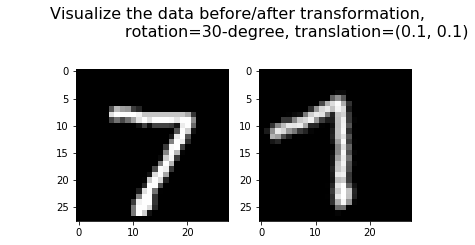

In [2]:
"""
This tutorial shows how to generate adversarial examples using FGSM
and train a model using adversarial training with TensorFlow.
It is very similar to mnist_tutorial_keras_tf.py, which does the same
thing but with a dependence on keras.
The original paper can be found at:
https://arxiv.org/abs/1412.6572
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import tensorflow as tf
import math
from tensorflow.python.platform import flags
import logging

from cleverhans.loss import LossCrossEntropy
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import train, model_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans_tutorials.tutorial_models import ModelBasicCNN
from cleverhans.spatial_transformer import transformer

FLAGS = flags.FLAGS


def mnist_tutorial(train_start=0, train_end=60000, test_start=0,
                   test_end=10000, nb_epochs=6, batch_size=128,
                   learning_rate=0.001,
                   clean_train=True,
                   testing=False,
                   backprop_through_attack=False,
                   nb_filters=64, num_threads=None,
                   label_smoothing=True):
    """
    MNIST cleverhans tutorial
    :param train_start: index of first training set example
    :param train_end: index of last training set example
    :param test_start: index of first test set example
    :param test_end: index of last test set example
    :param nb_epochs: number of epochs to train model
    :param batch_size: size of training batches
    :param learning_rate: learning rate for training
    :param clean_train: perform normal training on clean examples only
                        before performing adversarial training.
    :param testing: if true, complete an AccuracyReport for unit tests
                    to verify that performance is adequate
    :param backprop_through_attack: If True, backprop through adversarial
                                    example construction process during
                                    adversarial training.
    :param clean_train: if true, train on clean examples
    :return: an AccuracyReport object
    """

    # Object used to keep track of (and return) key accuracies
    report = AccuracyReport()

    # Set TF random seed to improve reproducibility
    tf.set_random_seed(1234)

    # Set logging level to see debug information
    set_log_level(logging.INFO)

    # Create TF session
    if num_threads:
        config_args = dict(intra_op_parallelism_threads=1)
    else:
        config_args = {}
    sess = tf.Session(config=tf.ConfigProto(**config_args))

    # Get MNIST test data
    x_train, y_train, x_test, y_test = data_mnist(train_start=train_start,
                                                  train_end=train_end,
                                                  test_start=test_start,
                                                  test_end=test_end)
    # Use Image Parameters
    img_rows, img_cols, nchannels = x_train.shape[1:4]
    nb_classes = y_train.shape[1]

    if label_smoothing:
        label_smooth = .1
        y_train = y_train.clip(label_smooth /
                               (nb_classes-1), 1. - label_smooth)

    # Define input TF placeholder
    x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                          nchannels))
    y = tf.placeholder(tf.float32, shape=(None, nb_classes))

    # Train an MNIST model
    train_params = {
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
    eval_params = {'batch_size': batch_size}
    rng = np.random.RandomState([2017, 8, 30])
    sess = tf.Session()

    def do_eval(preds, x_set, y_set, report_key, is_adv=None):
        acc = model_eval(sess, x, y, preds, x_set, y_set, args=eval_params)
        setattr(report, report_key, acc)
        if is_adv is None:
            report_text = None
        elif is_adv:
            report_text = 'adversarial'
        else:
            report_text = 'legitimate'
        if report_text:
            print('Test accuracy on %s examples: %0.4f' % (report_text, acc))

    if clean_train:
        model = ModelBasicCNN('model1', nb_classes, nb_filters)
        preds = model.get_logits(x)
        loss = LossCrossEntropy(model, smoothing=0.1)

        def evaluate():
            do_eval(preds, x_test, y_test, 'clean_train_clean_eval', False)

        train(sess, loss, x, y, x_train, y_train, evaluate=evaluate,
              args=train_params, rng=rng, var_list=model.get_params())

        # Calculate testing error
        do_eval(preds, x_test, y_test, 'train_clean_test_clean_eval')

        # Calculate training error
        if testing:
            do_eval(preds, x_train, y_train, 'train_clean_train_clean_eval')

        # Define the range of transformations
        angles = np.linspace(-30, 30, 3)
        dxs = np.linspace(-0.1, 0.1, 2)
        dys = np.linspace(-0.1, 0.1, 2)

        # Initialize the transformation matrix
        for angle in angles:
            for dx in dxs:
                for dy in dys:
                    cos_angle = np.cos(angle / 180.0 * math.pi)
                    sin_angle = np.sin(angle / 180.0 * math.pi)
                    M = np.array([cos_angle, -sin_angle, dx,
                                  sin_angle, cos_angle, dy] * batch_size)
                    theta = tf.constant(M, shape=(batch_size, 6))

                    # Transform the input
                    out_size = (img_rows, img_cols)
                    adv_x = transformer(x, theta, out_size)
                    adv_x = tf.reshape(adv_x, (-1, img_rows, img_rows, 1))
                    preds_adv = model.get_logits(adv_x)

                    # Evaluate the accuracy of the MNIST model on adversarial examples
                    print('Rotation %f, Translation X, Y: %f %f' %
                          (angle, dx, dy))
                    do_eval(preds_adv, x_test, y_test, 'clean_train_adv_eval', True)            
                    print('---')
        
        # Visualize the data before and after transformation (angle=30, translation=(0.1, 0.1))
        x_values, adv_x_values = sess.run([x, adv_x], feed_dict={x: x_test[:128]})
        x_pixels = x_values[0].reshape((28, 28))
        adv_x_pixels = adv_x_values[0].reshape((28, 28))
        
        from matplotlib import pyplot as plt
        plt.suptitle("Visualize the data before/after transformation,\n \
                      rotation=30-degree, translation=(0.1, 0.1)", fontsize=16)
        image1 = plt.subplot(121)
        image2 = plt.subplot(122)
        image1.imshow(x_pixels, cmap='gray')
        image2.imshow(adv_x_pixels, cmap='gray')

        # Calculate training error
        if testing:
            do_eval(preds_adv, x_train, y_train, 'train_clean_train_adv_eval')

    return report

def main(argv=None):
    mnist_tutorial(nb_epochs=FLAGS.nb_epochs, batch_size=FLAGS.batch_size,
                   learning_rate=FLAGS.learning_rate,
                   clean_train=FLAGS.clean_train,
                   backprop_through_attack=FLAGS.backprop_through_attack,
                   nb_filters=FLAGS.nb_filters)


if __name__ == '__main__':
    flags.DEFINE_integer('nb_filters', 64, 'Model size multiplier')
    flags.DEFINE_integer('nb_epochs', 6, 'Number of epochs to train model')
    flags.DEFINE_integer('batch_size', 128, 'Size of training batches')
    flags.DEFINE_float('learning_rate', 0.001, 'Learning rate for training')
    flags.DEFINE_bool('clean_train', True, 'Train on clean examples')
    flags.DEFINE_bool('backprop_through_attack', False,
                      ('If True, backprop through adversarial example '
                       'construction process during adversarial training'))

    tf.app.run()